# Explicit Matrix Factorization: ALS, SGD, and All That Jazz

In [2]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=1, suppress=True)
np.random.seed(0)

In [27]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('data/ml-100k/u.data', sep='\t', names=names) # читаем файл в датафрейм
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
#======================изучаю pandas===================================

In [50]:
np.arange(1,8)

array([1, 2, 3, 4, 5, 6, 7])

In [81]:
# тестовый датафрейм
df1 = pd.DataFrame({'user': np.random.randint(1,7,20), 
                    'rating': np.random.randint(1,6,20)},
                  index=['film1', 'film2', 'film3','film4', 'film6', 'film6','film7','film8',
                        'film9', 'film10', 'film11','film12', 'film13', 'film14','film15','film16',
                        'film17', 'film18','film19','film20'])

df1

,user,rating
film1,6,3
film2,2,4
film3,2,5
film4,5,1
film6,1,3
film6,6,4
film7,1,4
film8,4,2
film9,3,4
film10,4,5


In [82]:
n_user1 = df1.user.unique().shape[0] #количество уникальных значений
n_rating2 = df1.rating.unique().shape[0]
film_ratings = np.zeros((n_user1, n_rating2))

for row in df1.itertuples(): # itertuples перебирает все строки датафрейма
    print(row[1], row[2])
    film_ratings[row[1]-1, row[2]-1] = row[1]+row[2]
film_ratings

6 3
2 4
2 5
5 1
1 3
6 4
1 4
4 2
3 4
4 5
3 4
5 4
4 2
6 2
6 2
4 4
1 3
4 3
1 5
5 4


array([[ 0.,  0.,  4.,  5.,  6.],
       [ 0.,  0.,  0.,  6.,  7.],
       [ 0.,  0.,  0.,  7.,  0.],
       [ 0.,  6.,  7.,  8.,  9.],
       [ 6.,  0.,  0.,  9.,  0.],
       [ 0.,  8.,  9., 10.,  0.]])

In [93]:
tst_ratings1 = np.random.choice(film_ratings[3, :].nonzero()[0], #выбираем 10 ненулевых
                                        size=3, # рейтингов 
                                        replace=False)
train00 = film_ratings.copy()
 # array([1, 3, 2], dtype=int64)
train00[3, tst_ratings1] = 0.
train00

array([[ 0.,  0.,  4.,  5.,  6.],
       [ 0.,  0.,  0.,  6.,  7.],
       [ 0.,  0.,  0.,  7.,  0.],
       [ 0.,  0.,  7.,  0.,  0.],
       [ 6.,  0.,  0.,  9.,  0.],
       [ 0.,  8.,  9., 10.,  0.]])

In [94]:
film_ratings[3, :].nonzero()[0]

array([1, 2, 3, 4], dtype=int64)

In [95]:
np.random.choice(film_ratings[3, :].nonzero()[0], #выбираем 10 ненулевых
                                        size=3, # рейтингов 
                                        replace=False)

array([4, 2, 1], dtype=int64)

In [87]:
sparsity = 100 * float(len(film_ratings.nonzero()[0]))/(n_user1*n_rating2)
sparsity

50.0

In [25]:
df1.num_legs.unique().shape, df1.num_wings.unique().shape

((3,), (2,))

In [ ]:
print('Количество элементов=',len(ratings))
print('Количество ненулевых элементов=',len(ratings.nonzero()))

In [12]:
# скалярное произведение одномерных массивов (векторов)
a11 = np.array([2, 3, 4])
b11 = np.array([1, 2, 3])

print(a11*b11)
np.dot(a11, b11), a11.T.dot(b11), (a11*b11).sum() 

[ 2  6 12]


(20, 20, 20)

In [ ]:
#====================закончил=изучать=pandas===================================

In [29]:
# создаём матрицу user-item

n_users = df.user_id.unique().shape[0]
print('n_users=',n_users)
n_items = df.item_id.unique().shape[0]
print('n_items=',n_items)
ratings = np.zeros((n_users, n_items)) # создаем нулевую матрицу размера n_users X n_items

for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3] # перебрали все строки и 
    # значения уменьшенные на 1 сделали индексами элемента матрицы рейтингов ratings и этому
    # элементу присвоили значение рейтинга
print('Количество элементов=',len(ratings))
print('Количество ненулевых элементов=',len(ratings.nonzero()))
ratings

n_users= 943
n_items= 1682
Количество элементов= 943
Количество ненулевых элементов= 2


array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [11]:
print (str(n_users) + ' users')
print (str(n_items) + ' items')
sparsity = float(len(ratings.nonzero()[0])) #количество ненулевых элементов
sparsity /= (ratings.shape[0] * ratings.shape[1]) #доля ненулевых элементов 
sparsity *= 100 #процент ненулевых элементов
print ('Разреженность Sparsity: {:4.2f}%'.format(sparsity))

943 users
1682 items
Разреженность Sparsity: 6.30%


In [14]:
# создаём две матрицы train и test
# Мы разделим наши данные на обучающую и тестовую матрицу, 
# удалив 10 оценок для каждого пользователя из обучающего набора и поместив их в набор тестов.

def train_test_split(ratings):
    test = np.zeros(ratings.shape) #создаём нулевую матрицу рамера матрицы ratings
    train = ratings.copy() # в train копируем матрицу рейтингов
    for user in range(ratings.shape[0]): # для каждого номера usera
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], #выбираем 10 ненулевых
                                        size=10, # рейтингов и 
                                        replace=False)
        train[user, test_ratings] = 0. # вместо этих 10 ненулевых рейтингов вставляем ноль
        test[user, test_ratings] = ratings[user, test_ratings] # вместо нулей на эти места всавляем 
                                                               # 10 ненулевых рейтингов
        
    # Test and training are truly disjoint
    # Assert — это специальная конструкция, позволяющая проверять предположения 
    # о значениях произвольных данных в произвольном месте программы.
    # np.all проверяет все ли элементы массива вдоль данной оси имеют значение True.
    assert(np.all((train * test) == 0)) 
    return train, test

In [15]:
train, test = train_test_split(ratings) # получили две матрицы train и test

In [16]:
train, test

(array([[5., 3., 4., ..., 0., 0., 0.],
        [4., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 5., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [5., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

## Введение  в матричную факторизацию для рекомендательных систем

## Чередование наименьших квадратов для обучения модели

### Производные ALS

![ALSderivative.png](ALSderivative.png "Производные по векторам")

## Вычисления: превращение математики в код

In [27]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            Матрица размером User x Item содержащая соответствующие рейтинги
        
        n_factors : (int)
            Количество скрытых факторов модели
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Регуляризация для скрытых факторов объектов (что за хрень?)
            Regularization term for item latent factors
        
        user_reg : (float)
            Регуляризация для скрытых факторов объектов
            Regularization term for user latent factors
        
        verbose : (bool)
            Следует ли распечатывать прогресс обучения
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs) # скалярное произведение одномерных массивов (векторов)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tтекущая итерация: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)                
        return predictions
    
    # r^ui = xTu x yi = SUM_k x_uk y_ki - оценка рейтинга 
    # u-го пользователя присвоенный i-му фильму
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [25]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [28]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

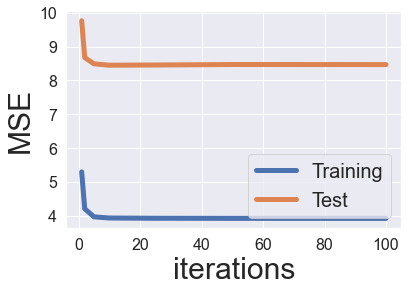

In [30]:
plot_learning_curve(iter_array, MF_ALS)

### Оптимизация параметров модели ALS

In [31]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=30., item_reg=30.)

iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

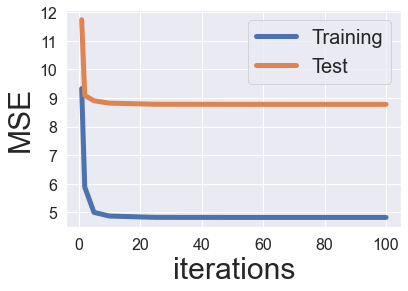

In [32]:
plot_learning_curve(iter_array, MF_ALS)

In [34]:
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.1, 1., 10., 100.]
regularizations.sort()
iter_array = [1, 2, 5, 10, 25, 50, 100]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print ('Factors: {}'.format(fact))
    for reg in regularizations:
        print ('Regularization: {}'.format(reg))
        MF_ALS = ExplicitMF(train, n_factors=fact, \
                            user_reg=reg, item_reg=reg)
        MF_ALS.calculate_learning_curve(iter_array, test)
        min_idx = np.argmin(MF_ALS.test_mse)
        if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params['test_mse'] = MF_ALS.test_mse[min_idx]
            best_params['model'] = MF_ALS
            print ('New optimal hyperparameters')
            print (pd.Series(best_params))

Factors: 5
Regularization: 0.1
New optimal hyperparameters
n_factors                                                    5
reg                                                        0.1
n_iter                                                       5
train_mse                                              6.14742
test_mse                                               8.79834
model        <__main__.ExplicitMF object at 0x000000000B445...
dtype: object
Regularization: 1.0
Regularization: 10.0
Regularization: 100.0
Factors: 10
Regularization: 0.1
New optimal hyperparameters
n_factors                                                   10
reg                                                        0.1
n_iter                                                     100
train_mse                                              5.40215
test_mse                                               8.21184
model        <__main__.ExplicitMF object at 0x000000000B41A...
dtype: object
Regularization: 1.0
Regularization

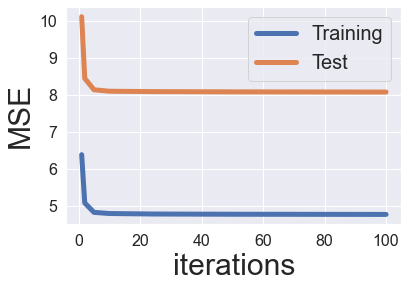

In [35]:
best_als_model = best_params['model']
plot_learning_curve(iter_array, best_als_model)

In [37]:
best_params

{'n_factors': 20,
 'reg': 0.1,
 'n_iter': 100,
 'train_mse': 4.760697883028721,
 'test_mse': 8.07724633572245,
 'model': <__main__.ExplicitMF at 0xb32abb0>}